In [17]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib as mpl
#import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from   invisible_cities.database           import load_db
from   invisible_cities.io.pmaps_io        import load_pmaps
from   invisible_cities.io.pmaps_io        import load_pmaps_as_df
from   invisible_cities.io.pmaps_io        import s1s_from_df
from   invisible_cities.io.pmaps_io        import s2s_from_df

from   invisible_cities.core.exceptions        import ClusterEmptyList
from   invisible_cities.core.exceptions        import SipmZeroCharge
from   invisible_cities.core.exceptions        import SipmEmptyListAboveQthr
from   invisible_cities.core.system_of_units_c import units

from invisible_cities.reco                 import pmaps_functions  as pmp
from invisible_cities.reco.xy_algorithms   import corona
from invisible_cities.reco.tbl_functions   import get_event_numbers_and_timestamps_from_file_name
from invisible_cities.reco.pmaps_functions import rebin_peak

In [18]:
### Useful parameters for plots
plt.rcParams["font.size"] = 15

In [19]:
def plot_test_event(l_X,l_Y,l_Q,l_X0,l_Y0):
    """
    Plots a SiPM map in the NEW Geometry
    """
    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(15.0)
    fig.set_figwidth(20.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    plt.scatter(l_X,l_Y,c=l_Q)
    plt.colorbar()
#    for xx,yy,qq in zip(l_X,l_Y,l_Q):
#        r = Ellipse(xy=(xx, yy), width=4., height=4.);
#        r.set_facecolor('0');
#        r.set_alpha(qq);
#        ax1.add_artist(r);

    # place a red cross for actual EL points
    ax1.scatter(l_X0,l_Y0,marker='x',s=100,color='red')
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");
    
    #fig.savefig('slice_MC_file10_evt400188.png')

In [20]:
# identify the correct file to look into
expected_no = 373
#hit_file = '/Users/paola/Software/ic_data/run6352/pmaps/pmaps_0001_6352_trigger2_v0.9.9_20180921_krth1300.h5'
#hit_file = '/Users/paola/Software/ic_data/pmaps_0001_6350_trigger1_v0.9.9_20180921_krbg1300.h5'
#hit_base_file = '/Users/paola/Software/ic_data/TlMC/pmaps/Tl208_NEW_v1_03_01_nexus_v5_03_04_UPPER_PORT_10.2bar_v0.9.8_20180507_pmaps.{}.h5'
#start = 15
try:
    load_pmaps(hit_file)
except:
    print('File not found')
        
event_numbers, timestamps = get_event_numbers_and_timestamps_from_file_name(hit_file)
print('Number of events = {}'.format(len(event_numbers)))
for evt_number in event_numbers:
    #print(evt_number)
    if evt_number == expected_no:
        print('Expected event in file {0}'.format(hit_file))
            

Number of events = 336
Expected event in file /Users/paola/Software/ic_data/pmaps_0001_6350_trigger1_v0.9.9_20180921_krbg1300.h5


## Data

In [26]:
run_number_data = 6350
dv = 0.001
dv_data = 0.000920869862957205
corona_opts_data   = {
    "Qthr"          : 0.001,
    "Qlm"           : 30.,
    "lm_radius"     : 0.,
    "new_lm_radius" : 0.,
    "msipm"         :  1,
}

In [27]:
DataSiPM        = load_db.DataSiPM(run_number_data)
data_xs         = DataSiPM.X.values
data_ys         = DataSiPM.Y.values

In [28]:
def compute_xy_position(s2, slice_no, DataSiPM):
    IDs = s2.sipms.ids
    pos = np.array([np.array([x,y]) for x,y in zip(data_xs[IDs], data_ys[IDs])])
    Qs  = np.array(s2s[peak_no].sipms.time_slice(slice_no))
    #print(pos, Qs)
    return corona(pos, Qs, DataSiPM, **corona_opts_data), pos, Qs

In [29]:
evt_no = 373
peak_no = 0
n_rebin = 2
drift_v = dv_data

17


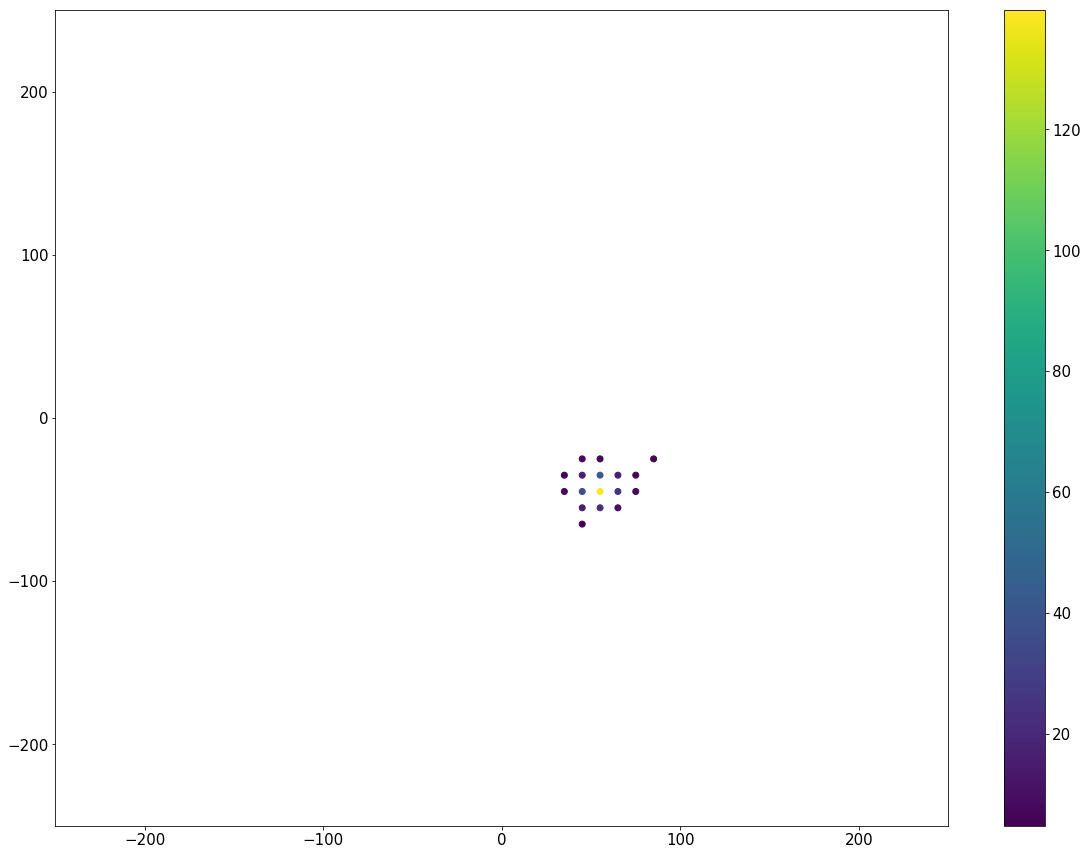

In [32]:
file_name = hit_file
#PATH_IN = '/Users/paola/Software/ic_data/pairs/electrons_2615keV_z250mm_pmaps.0.h5'
slice_no = 1

pmap_dict = load_pmaps(file_name)
pmap = pmap_dict.get(evt_no, None)
if pmap == None:
    print('No pmaps')

s1    = pmap.s1s
s2raw = pmap.s2s
### Reject events with no S1, S2
if not s1 or not s2raw:
    print('No S1 or S2')
if len(s1) != 1:
    print('More than one S1')

s2s = [rebin_peak(s2r, n_rebin) for s2r in s2raw]

s1e = s1[0].pmts.sum_over_sensors
S1t = s1[0].time_at_max_energy

t_slice = s2s[peak_no].times[slice_no]
z       = (t_slice - S1t) * drift_v 

s2 = s2s[peak_no]
IDs = s2.sipms.ids
pos = np.array([np.array([x,y]) for x,y in zip(data_xs[IDs], data_ys[IDs])])
Qs  = np.array(s2s[peak_no].sipms.time_slice(slice_no))

print(len(Qs))
xvals = []; yvals = []; qvals = []
for p, q in zip(pos, Qs):
    if q > 0:
        #print(p, q)
        xvals.append(p[0])
        yvals.append(p[1])
        qvals.append(q)

# set up the figure
fig = plt.figure();
ax1 = fig.add_subplot(111);
fig.set_figheight(15.0)
fig.set_figwidth(20.0)
ax1.axis([-250, 250, -250, 250]);

# plot the SiPM pattern
plt.scatter(xvals,yvals,c=qvals)
plt.colorbar()

In [35]:
file_name = hit_file
#PATH_IN = '/Users/paola/Software/ic_data/pairs/electrons_2615keV_z250mm_pmaps.0.h5'
slice_no = 4

pmap_dict = load_pmaps(file_name)
pmap = pmap_dict.get(evt_no, None)
if pmap == None:
    print('No pmaps')

s1    = pmap.s1s
s2raw = pmap.s2s
### Reject events with no S1, S2
if not s1 or not s2raw:
    print('No S1 or S2')
if len(s1) != 1:
    print('More than one S1')

s2s = [rebin_peak(s2r, n_rebin) for s2r in s2raw]

s1e = s1[0].pmts.sum_over_sensors
S1t = s1[0].time_at_max_energy

t_slice = s2s[peak_no].times[slice_no]
z       = (t_slice - S1t) * drift_v 

#print("Tot energy of peak {} = {}".format(peak_no, np.sum(S2.s2d[peak_no][1])))
clusters = []

try:
    clusters, pos, Qs = compute_xy_position(s2s[peak_no], slice_no, DataSiPM)
except ClusterEmptyList:
    print('No clusters')
except SipmZeroCharge:
    print('No charge in SiPMs')

print("Found {0} clusters at t {1}".format(len(clusters), t_slice))


x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("{0} {1} {2}".format(c.pos[0], c.pos[1], z))
    
xvals = []; yvals = []; qvals = []

for p, q in zip(pos, Qs):
    if q > 0:
        #print(p, q)
        xvals.append(p[0])
        yvals.append(p[1])
        qvals.append(q)


plot_test_event(xvals,yvals,qvals,x0vals,y0vals)
#print(np.sort(Qs[Qs>0]))


IndexError: index 4 is out of bounds for axis 0 with size 3

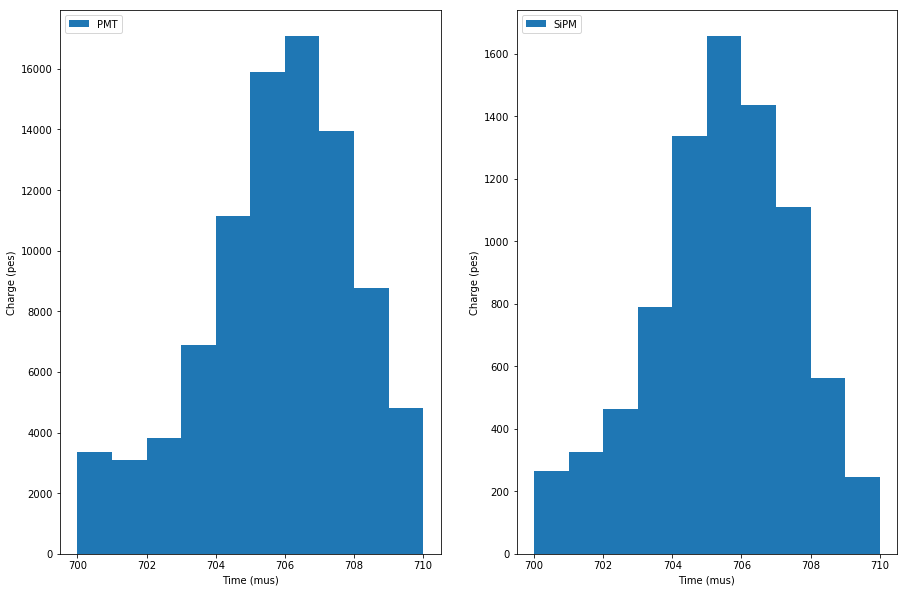

In [17]:
fig = plt.figure(figsize=(15, 10))
range1 = 700
range2 = 710
bins = range2-range1

ax = fig.add_subplot(1, 2, 1)

t = s2raw[peak_no].times * 0.001
charges = s2raw[peak_no].pmts.sum_over_sensors
ax.hist(t, bins=bins, weights=charges, range=(range1,range2), label='PMT')
lnd = plt.legend(loc=2)
plt.xlabel('Time (mus)')
plt.ylabel('Charge (pes)')

ax = fig.add_subplot(1, 2, 2)

charges = s2raw[peak_no].sipms.sum_over_sensors
ax.hist(t, bins=bins, weights=charges, range=(range1,range2), label='SiPM')
lnd = plt.legend(loc=2)
plt.xlabel('Time (mus)')
plt.ylabel('Charge (pes)')

### Write all hits

In [27]:
def split_energy(total_e, clusters):
    if len(clusters) == 1:
        return [total_e]
    qs = np.array([c.Q for c in clusters])
    return total_e * qs / np.sum(qs)


In [38]:
pmap_dict = load_pmaps(file_name)
pmap = pmap_dict.get(evt_no, None)
if pmap == None:
    print('No pmaps')

s1    = pmap.s1s
s2raw = pmap.s2s
### Reject events with no S1, S2
if not s1 or not s2raw:
    print('No S1 or S2')
if len(s1) != 1:
    print('More than one S1')

s2s = [rebin_peak(s2r, n_rebin) for s2r in s2raw]

s1e = s1[0].pmts.sum_over_sensors
S1t = s1[0].time_at_max_energy

for slice_no in range(len(s2s[peak_no].times)):
    t_slice = s2s[peak_no].times[slice_no]
    z       = (t_slice - S1t) * drift_v 
    try:
        clusters, pos, Qs = compute_xy_position(s2s[peak_no], slice_no)
    except ClusterEmptyList:
        #print('No clusters')
        continue
    except SipmZeroCharge:
        #print('No charge in SiPMs')
        continue
    except(SipmEmptyListAboveQthr):
        #print('No charge over threshold in SiPMs')
        continue
    
    slice_energy = s2s[peak_no].pmts.sum_over_sensors[slice_no]
    energies = split_energy(slice_energy, clusters)
    for c, e in zip(clusters, energies):
        print("{0} {1} {2} {3}".format(c.pos[0], c.pos[1], z, e))

14.74564934194026 162.3054567683913 329.3223437062522 4854.491147312271
14.340491375176322 155.15754072336128 329.3223437062522 4330.293440048225
3.4009346473557676 154.00963252352182 329.3223437062522 3056.798603557473
15.431390374220026 162.8389800280753 331.0639963889364 5818.779402083419
14.747013008700144 154.81321684927826 331.0639963889364 5103.919402756273
25.692433187582047 166.13393336395086 331.0639963889364 2715.8777274232116
3.1043280594128624 152.96242038649194 331.0639963889364 3722.449131318301
16.01645755281018 145.24605495740082 331.0639963889364 2441.7325329928426
-5.549412778699581 154.62156468096163 331.0639963889364 3581.10056807439
15.696179842228249 162.7695619604895 332.8605559371995 4871.188646750038
14.665632610404739 154.75916791699805 332.8605559371995 4212.529390410079
2.418242040733476 153.028685056586 332.8605559371995 3388.885924336312
25.74062969199072 165.50784155885987 332.8605559371995 2354.2601847634246
-12.84445409643785 153.8243979800747 332.8605

## MC

In [11]:
corona_opts   = {
    "Qthr"          : 3,
    "Qlm"           : 55.,
    "lm_radius"     : 0.,
    "new_lm_radius" : 15.,
    "msipm"         :  7,
}

run_number = -6202
DataSiPM        = load_db.DataSiPM(run_number)
data_xs         = DataSiPM.X.values
data_ys         = DataSiPM.Y.values

In [12]:
def compute_xy_position(s2, slice_no):
    IDs = s2.sipms.ids
    pos = np.array([np.array([x,y]) for x,y in zip(data_xs[IDs], data_ys[IDs])])
    Qs  = np.array(s2s[peak_no].sipms.time_slice(slice_no))
    return corona(pos, Qs, **corona_opts), pos, Qs

In [ ]:
file_name = '/Users/paola/Software/ic_data/TlMC/pmaps/Tl208_NEW_v1_03_01_nexus_v5_03_04_UPPER_PORT_10.2bar_v0.9.8_20180507_pmaps.0.h5'
slice_no = 2
evt_no = 427
peak_no = 0
n_rebin = 2

s1df, s2df, sidf, s1pmtdf, s2pmtdf = load_pmaps_as_df(file_name)
s1  = s1s_from_df(s1df   [s1df   .event == evt_no],
                  s1pmtdf[s1pmtdf.event == evt_no])
s2raw = s2s_from_df(s2df   [s2df   .event == evt_no],
                    s2pmtdf[s2pmtdf.event == evt_no],
                    sidf   [sidf   .event == evt_no])

s2s = [rebin_peak(s2r, n_rebin) for s2r in s2raw]

s1e = s1[0].pmts.sum_over_sensors
S1t = s1[0].time_at_max_energy

t_slice = s2s[peak_no].times[slice_no]
z       = (t_slice - S1t) * 0.001  # drift_v = 1.0

#print("Tot energy of peak {} = {}".format(peak_no, np.sum(S2.s2d[peak_no][1])))
clusters = []

try:
    clusters, pos, Qs = compute_xy_position(s2s[peak_no], slice_no)
except ClusterEmptyList:
    print('No clusters')
except SipmZeroCharge:
    print('No charge in SiPMs')

print("Found {0} clusters at t {1}".format(len(clusters), t_slice))


x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("cluster ({0},{1},{2})".format(c.pos[0],c.pos[1],z))
    
xvals = []; yvals = []; qvals = []

for p, q in zip(pos, Qs):
    if q > 0:
        xvals.append(p[0])
        yvals.append(p[1])
        qvals.append(q)
        #print(p[0], p[1], q)


plot_test_event(xvals,yvals,qvals,x0vals,y0vals)
#print(np.sort(Qs[Qs>0]))

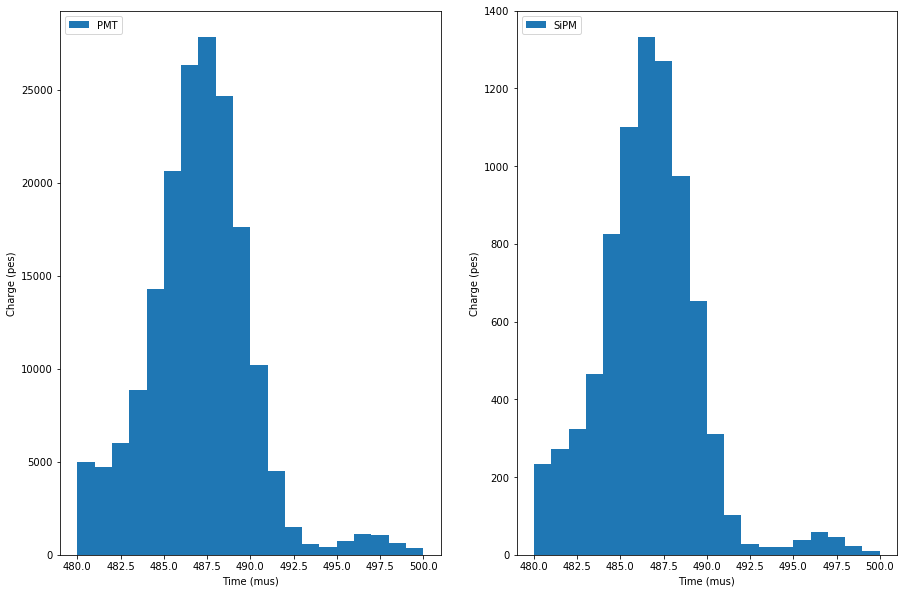

In [20]:
fig = plt.figure(figsize=(15, 10))
range1 = 480
range2 = 500
bins = range2-range1

ax = fig.add_subplot(1, 2, 1)

t = s2raw[peak_no].times * 0.001
charges = s2raw[peak_no].pmts.sum_over_sensors
ax.hist(t, bins=bins, weights=charges, range=(range1,range2), label='PMT')
lnd = plt.legend(loc=2)
plt.xlabel('Time (mus)')
plt.ylabel('Charge (pes)')

ax = fig.add_subplot(1, 2, 2)

charges = s2raw[peak_no].sipms.sum_over_sensors
ax.hist(t, bins=bins, weights=charges, range=(range1,range2), label='SiPM')
lnd = plt.legend(loc=2)
plt.xlabel('Time (mus)')
plt.ylabel('Charge (pes)')

In [18]:
def split_energy(total_e, clusters):
    if len(clusters) == 1:
        return [total_e]
    qs = np.array([c.Q for c in clusters])
    return total_e * qs / np.sum(qs)

In [19]:
s1df, s2df, sidf, s1pmtdf, s2pmtdf = load_pmaps_as_df(file_name)
s1  = s1s_from_df(s1df   [s1df   .event == evt_no],
                  s1pmtdf[s1pmtdf.event == evt_no])
s2raw = s2s_from_df(s2df   [s2df   .event == evt_no],
                    s2pmtdf[s2pmtdf.event == evt_no],
                    sidf   [sidf   .event == evt_no])

### Reject events with no S1, S2
if not s1 or not s2raw:
    print('No S1 or S2')
if len(s1) != 1:
    print('More than one S1')

s2s = [rebin_peak(s2r, n_rebin) for s2r in s2raw]

s1e = s1[0].pmts.sum_over_sensors
S1t = s1[0].time_at_max_energy

for slice_no in range(len(s2s[peak_no].times)):
    t_slice = s2s[peak_no].times[slice_no]
    z       = (t_slice - S1t) * 0.001 
    try:
        clusters, pos, Qs = compute_xy_position(s2s[peak_no], slice_no)
    except ClusterEmptyList:
        #print('No clusters')
        continue
    except SipmZeroCharge:
        #print('No charge in SiPMs')
        continue
    except(SipmEmptyListAboveQthr):
        #print('No charge over threshold in SiPMs')
        continue
    
    slice_energy = s2s[peak_no].pmts.sum_over_sensors[slice_no]
    energies = split_energy(slice_energy, clusters)
    for c, e in zip(clusters, energies):
        print("{0} {1} {2} {3}".format(c.pos[0], c.pos[1], z, e))

66.85690702423592 117.23522712134924 318.0831875 7296.223544590697
66.21509053388877 124.57983152318653 318.0831875 6244.85643354771
76.50357906055619 114.70641560425388 318.0831875 4209.510231822529
66.5347505855926 117.65283099435123 319.9470625 13566.70590856843
66.13370733031816 124.5825541348113 319.9470625 11807.981436228787
76.62995921603844 115.49742945758787 319.9470625 7905.25186169749
55.8987456880866 126.93952021516046 319.9470625 5189.122998510596
84.15780369006347 113.88421509230672 319.9470625 3536.138933966758
56.56548686950594 146.43109810345229 319.9470625 2105.844271184189
65.03928994819844 124.21473638371289 321.79846875 14202.025840792525
66.27293481149637 117.01236941707234 321.79846875 9111.774407292618
77.469298749668 116.56383559107047 321.79846875 6478.3979901856055
55.7964517213316 128.41540850338674 321.79846875 6508.978857099931
65.91106716250536 134.91794934565567 321.79846875 6569.399656625965
84.88347035885894 115.28376860563426 321.79846875 3182.7352597

In [9]:
DataSiPM_0 = load_db.DataSiPM(0)
DataSiPM_1 = load_db.DataSiPM(1)

In [35]:
DataSiPM_1.X.values

array([-235., -235., -235., ...,  235.,  235.,  235.])

In [37]:
DataSiPM_1.Y.values

array([ 45.,  55.,  65., ..., -65., -55., -45.])

In [36]:
np.stack([DataSiPM_1.X.values, DataSiPM_1.Y.values], axis=0)

array([[-235., -235., -235., ...,  235.,  235.,  235.],
       [  45.,   55.,   65., ...,  -65.,  -55.,  -45.]])

In [4]:
DataSiPM.Active.values.astype(bool)

array([ True,  True,  True, ...,  True,  True,  True])

In [23]:
np.repeat(np.arange(3), 4)


array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])